In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras

In [2]:
trainData = pd.read_csv("train.csv")
testData = pd.read_csv("test.csv")

In [3]:
trainData.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
def developFeatures(Data):
    
    # Extract and categorize titles of the passengers travelling
    Data['Name'] = Data.Name.str.split(', ').map(lambda x: x[1])
    Data['Title'] = Data.Name.str.split('.').map(lambda x: x[0])

    Data['Title'] = Data['Title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other_Titles')                    
    Data['Title'] = Data['Title'].replace('Mlle', 'Miss')
    Data['Title'] = Data['Title'].replace('Ms', 'Miss')
    Data['Title'] = Data['Title'].replace('Mme', 'Mrs')
    Data['Title'] = Data['Title'].replace(np.nan, 'None')

    encodedCols = pd.get_dummies(Data['Title'])
    Data = Data.join(encodedCols)

    # Extract ticket number of the passenger
    #Data = Data[Data.Ticket.apply(lambda x: x.isnumeric())]
    #Data['Ticket'] = Data['Ticket'].astype(int)


    # Defining Family Size
    Data['Fam'] = Data['SibSp']+ Data['Parch'] + 1

    # Categorize age into groups 
    Data['Age'] = Data['Age'].fillna(np.random.randint(Data['Age'].mean() - Data['Age'].std(),    Data['Age'].mean() + Data['Age'].std()))
    Data['categoricalAge'] = pd.cut(Data['Age'], bins= [0, 9, 19, 29, 39, 49, 59, 69, 79, 89], labels= ['1','2', '3', '4', '5', '6', '7', '8', '9'] ).astype(int)

    # Converting the categories to numerical data
    Data['Sex'] = Data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Categorize fare into different categories
    Data['Fare'] = Data['Fare'].fillna(Data['Fare'].median())
    Data['Fare'] = np.log(Data['Fare']+1)
    #Data['FareCategory'] = pd.qcut(Data['Fare'],q= 6)


    # column to determine whether the passenger is travelling alone or not
    Data['IsAlone'] = 0
    Data.loc[Data['Fam'] == 1, ['IsAlone']] = 1

    return Data

trainData = developFeatures(trainData)
testData = developFeatures(testData)

In [6]:
trainData.info()
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    int32  
 5   Age             891 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Cabin           204 non-null    object 
 11  Embarked        889 non-null    object 
 12  Title           891 non-null    object 
 13  Master          891 non-null    uint8  
 14  Miss            891 non-null    uint8  
 15  Mr              891 non-null    uint8  
 16  Mrs             891 non-null    uint8  
 17  Other_Titles    891 non-null    uin

In [7]:
trainData.head(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Title,Master,Miss,Mr,Mrs,Other_Titles,Fam,categoricalAge,IsAlone
0,1,0,3,Mr. Owen Harris,1,22.0,1,0,A/5 21171,2.110213,...,S,Mr,0,0,1,0,0,2,3,0
1,2,1,1,Mrs. John Bradley (Florence Briggs Thayer),0,38.0,1,0,PC 17599,4.280593,...,C,Mrs,0,0,0,1,0,2,4,0
2,3,1,3,Miss. Laina,0,26.0,0,0,STON/O2. 3101282,2.188856,...,S,Miss,0,1,0,0,0,1,3,1
3,4,1,1,Mrs. Jacques Heath (Lily May Peel),0,35.0,1,0,113803,3.990834,...,S,Mrs,0,0,0,1,0,2,4,0
4,5,0,3,Mr. William Henry,1,35.0,0,0,373450,2.202765,...,S,Mr,0,0,1,0,0,1,4,1
5,6,0,3,Mr. James,1,37.0,0,0,330877,2.246893,...,Q,Mr,0,0,1,0,0,1,4,1
6,7,0,1,Mr. Timothy J,1,54.0,0,0,17463,3.967694,...,S,Mr,0,0,1,0,0,1,6,1


In [8]:
'''Ftrs = trainData[['Ticket', 'Pclass']].groupby(['Pclass']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Pclass Vs Ticket")
plt.xlabel("Pclass")
plt.ylabel("Ticket")'''

# So the increase in ticket id means a lower Pclass

'Ftrs = trainData[[\'Ticket\', \'Pclass\']].groupby([\'Pclass\']).mean()\nFtrs.plot(kind= \'bar\')\nplt.title("Pclass Vs Ticket")\nplt.xlabel("Pclass")\nplt.ylabel("Ticket")'

Text(0, 0.5, 'Survival')

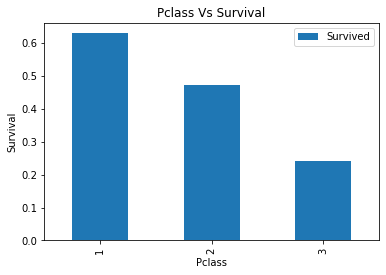

In [9]:
# PClass vs Survival
Ftrs = trainData[['Pclass', 'Survived']].groupby(['Pclass']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Pclass Vs Survival")
plt.xlabel("Pclass")
plt.ylabel("Survival")

Text(0, 0.5, 'Survival')

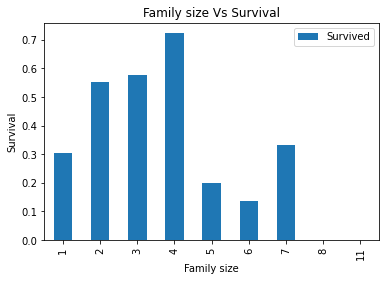

In [10]:
# Survival Vs FamilySize

#Plotting chance of survival Vs Size of the family/group
Ftrs = trainData[['Fam', 'Survived']].groupby(['Fam']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Family size Vs Survival")
plt.xlabel("Family size")
plt.ylabel("Survival")

Text(0, 0.5, 'Survival')

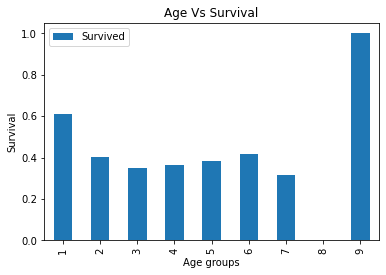

In [11]:
# AGE

Ftrs = trainData[['categoricalAge', 'Survived']].groupby(['categoricalAge']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Age Vs Survival")
plt.xlabel("Age groups")
plt.ylabel("Survival")

Text(0, 0.5, 'Survival')

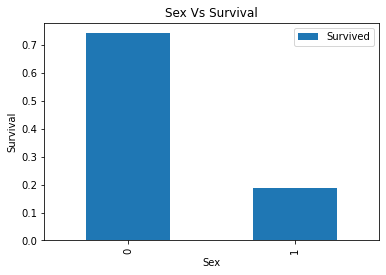

In [12]:
# SEX

# Plotting Sex Vs SurvivalRate
Ftrs = trainData[['Sex', 'Survived']].groupby(['Sex']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Sex Vs Survival")
plt.xlabel("Sex")
plt.ylabel("Survival")

Text(0, 0.5, 'Survival')

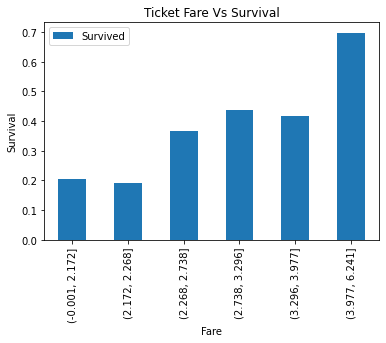

In [13]:
# FARE
trainData['FareCategory'] = pd.qcut(trainData['Fare'],q= 6)
Ftrs = trainData[['FareCategory', 'Survived']].groupby(['FareCategory']).mean()
Ftrs.plot(kind= 'bar')
plt.title("Ticket Fare Vs Survival")
plt.xlabel("Fare")
plt.ylabel("Survival")

In [14]:
trainData.drop(columns = ['Name',  'SibSp', 'Parch',  'Age' , 'Cabin', 'Embarked', 'Title', 'Ticket', 'FareCategory'], inplace= True)
trainData.dropna(inplace= True)
testData.drop(columns = ['Name', 'Age', 'SibSp', 'Parch', 'Cabin', 'Embarked', 'Title', 'Ticket'], inplace= True)


In [15]:
trainData.info()
testData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Sex             891 non-null    int32  
 4   Fare            891 non-null    float64
 5   Master          891 non-null    uint8  
 6   Miss            891 non-null    uint8  
 7   Mr              891 non-null    uint8  
 8   Mrs             891 non-null    uint8  
 9   Other_Titles    891 non-null    uint8  
 10  Fam             891 non-null    int64  
 11  categoricalAge  891 non-null    int32  
 12  IsAlone         891 non-null    int64  
dtypes: float64(1), int32(2), int64(5), uint8(5)
memory usage: 60.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  

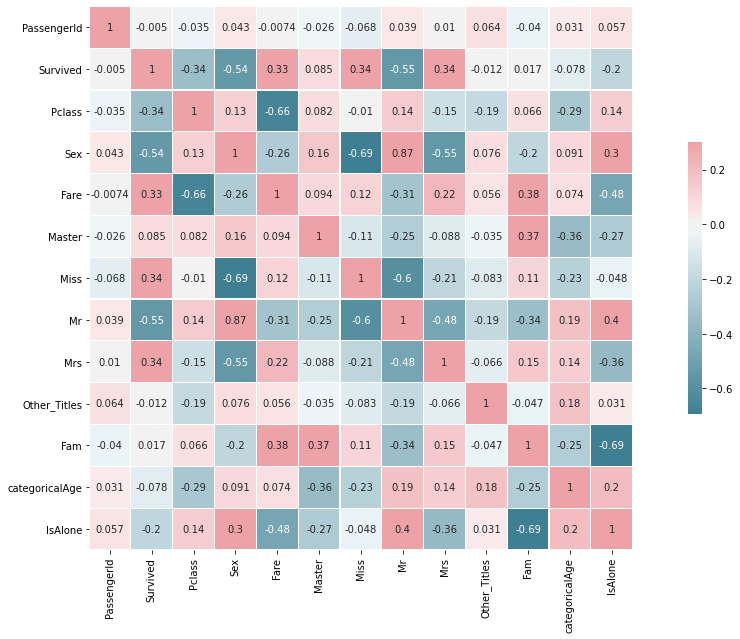

In [16]:
corr_mat = trainData.corr()
plt.figure(figsize = (20 ,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_mat, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=0.2, cbar_kws={"shrink": .5} , annot=True)

In [17]:
X = trainData.drop(columns= ['Survived', 'PassengerId'])

y = trainData['Survived']
X_test = testData.drop(columns=['PassengerId'])


#X_train, X_cv, y_train, y_cv = train_test_split(X, y,  test_size = 0.3, random_state = 5)

In [18]:
scaler = MinMaxScaler()

X.fillna(X.mean(), inplace=True)
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)


In [19]:
classifier1 = RandomForestClassifier(max_features= 5, n_estimators= 110 ,max_depth= 6, random_state=0, criterion='entropy')


In [20]:
cv_scores = cross_val_score(classifier1 , X_scaled, y, cv= 5)
cv_scores.mean()

0.827154604230745

In [21]:
classifier1.fit(X_scaled, y)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features=5,
                       n_estimators=110, random_state=0)

In [22]:
predictions1 = classifier1.predict(X_test_scaled)
output = pd.DataFrame()
output['PassengerId'] = testData['PassengerId']
output['Survived'] = predictions1
output.to_csv('predictions1.csv', index= False)

In [23]:
# Buliding NN classifier using tensorflow and keras libraries

def NNCreateModel() :
    classifier = tf.keras.Sequential()


    classifier.add(tf.keras.Input(shape= 11))
    classifier.add(tf.keras.layers.BatchNormalization())

    classifier.add(tf.keras.layers.Dense(64, activation= 'relu', activity_regularizer=tf.keras.regularizers.l1_l2(0.003)))
    classifier.add(tf.keras.layers.Dropout(0.1))

    classifier.add(tf.keras.layers.Dense(16, activation= 'relu', activity_regularizer= tf.keras.regularizers.l2(0.01)))
    classifier.add(tf.keras.layers.Dropout(0.1))

    classifier.add(tf.keras.layers.Dense(1, activation= 'sigmoid', activity_regularizer= tf.keras.regularizers.l1_l2(0.003)))

    opt = tf.keras.optimizers.SGD(0.006, momentum= 0.9)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

    classifier.summary()
    return classifier


In [24]:
def NNTrainTestModel(classifier, X_train, y_train):
    keras_history = classifier.fit(X_train, y_train , batch_size= 24, epochs=100, validation_split= 0.3)

In [25]:
classifier2 = NNCreateModel()
NNTrainTestModel(classifier2, X_scaled, y)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 11)                44        
_________________________________________________________________
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,869
Trainable params: 1,847
Non-trainable params: 22
_____________________________________________________

In [26]:
predictions2 = classifier2.predict(X_test_scaled)
predictions2=  tf.greater(predictions2, .5)
predictions2 = predictions2.numpy().astype(int)
output = pd.DataFrame()
output['PassengerId'] = testData['PassengerId']
output['Survived'] = predictions2
output.to_csv('predictions2.csv', index= False)

In [27]:
classifier3 = DecisionTreeClassifier(max_depth= 6, random_state=0, max_leaf_nodes= 8)
cv_scores = cross_val_score(classifier3 , X, y, cv= 5)
cv_scores.mean()

0.8237775406440273

In [28]:
classifier3 = DecisionTreeClassifier(max_depth= 6, random_state=0, max_leaf_nodes= 8).fit(X_scaled, y)

In [29]:

predictions3 = classifier3.predict(X_test_scaled)
output = pd.DataFrame()
output['PassengerId'] = testData['PassengerId']
output['Survived'] = predictions3
output.to_csv('predictions3.csv', index= False)